# SatSAM

In this notebook, we will finetune SAM on Aerial Image Dataset for building extraction.

Let's start by importing the necessary libraries:

In [1]:
from segmate.segmenter import SAM
from segmate.object_detector import GroundingDINO
from segmate import utils
import datasets
import numpy as np
import torch

C:\Users\vahid\anaconda3\lib\site-packages\groundingdino\models\GroundingDINO\ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


### Initializing SAM

To start using SegMate, we need to create an instance of the SAM class. Here, we create an instance called `sm` with the following parameters:

- `model_type`: Specifies the type of model to use. In this case, we are using the `vit_h` model. The options are `vit_b`, `vit_l` and `vit_h`.
- `checkpoint`: Specifies the path to the checkpoint file that contains the pre-trained weights of the model.
- `device`: Specifies the device to run the model on. In this case, we are using the `cuda` device for GPU acceleration.

This instance of the SegMate class serves as our toolkit for performing segmentation tasks with SAM. It encapsulates the model and provides convenient methods for inference and fine-tuning.

Let's create the instance and load the model:

In [2]:
model_checkpoint = '../../sam_vit_h.pth'

In [3]:
sm = SAM(model_type='vit_h', checkpoint=model_checkpoint, device='cuda')

In [4]:
# Function to calculate center of a building mask
def calculate_centers(contours):
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append((cX, cY))
    return centers

# Function to calculate bounding boxes around all buildings
def calculate_bounding_boxes(contours):
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x+w, y+h))
    return bounding_boxes

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image_path = '../../SAM_finetune/AerialImageDataset_spilt_patch/train/images/austin1_0_0.png'
image = cv2.imread(image_path)
mask_path = '../../SAM_finetune/AerialImageDataset_spilt_patch/train/gt/austin1_0_0.png'
gt_mask = cv2.imread(mask_path, 0)

# Threshold the image to make sure it's binary
_, binary_mask = cv2.threshold(gt_mask, 127, 255, cv2.THRESH_BINARY)

# Find contours which corresponds to the buildings
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [6]:
# Calculate centers and bounding boxes
centers = calculate_centers(contours)
bounding_boxes = calculate_bounding_boxes(contours)

In [9]:
gt_mask_ext_c = np.expand_dims(gt_mask, axis=0)
gt_mask_ext_c = np.concatenate((gt_mask_ext_c, gt_mask_ext_c, gt_mask_ext_c), axis=0)
gt_mask_ext_c = np.expand_dims(gt_mask_ext_c, axis=0)

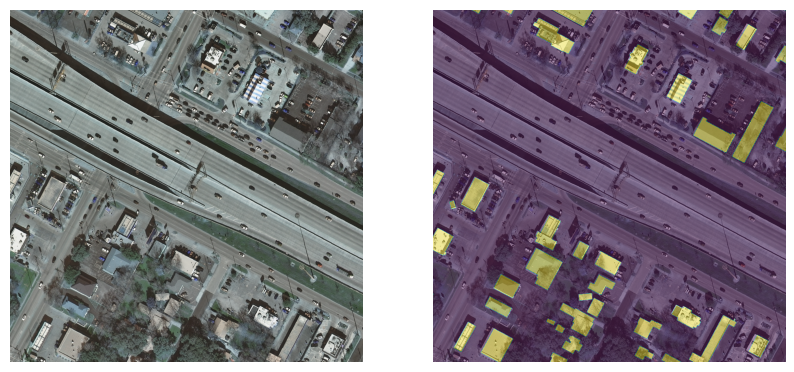

In [10]:
utils.show_masks(image, gt_mask_ext_c, size=5)

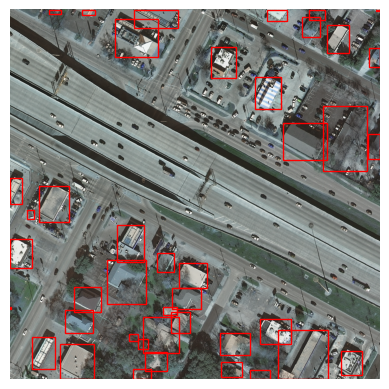

In [11]:
utils.show_bounding_boxes(image, utils.convert_sam_to_coco(bounding_boxes))

In [12]:
building_mask_bb = sm.segment(image, boxes_prompt=bounding_boxes)

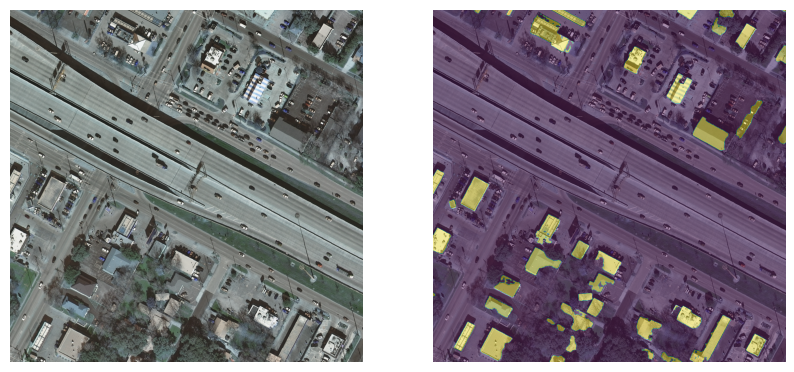

In [13]:
utils.show_masks(image, building_mask_bb, size=5)

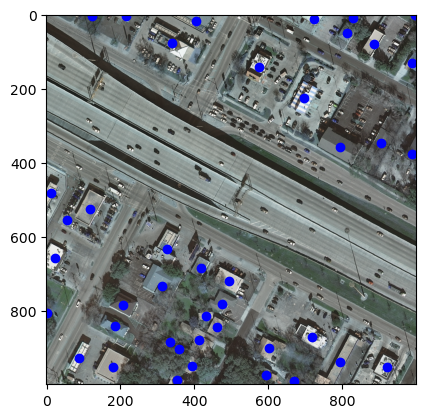

In [14]:
centers_labels = np.ones(len(centers))
utils.show_points(image, centers, centers_labels)

In [15]:
building_mask_p = sm.segment(image, points_prompt=[centers, centers_labels])

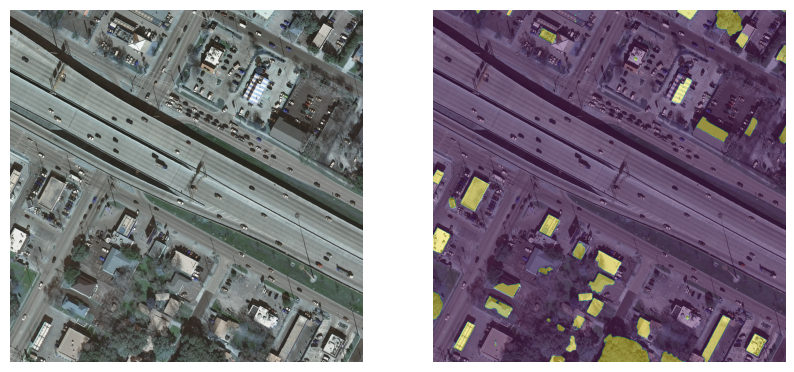

In [16]:
utils.show_masks(image, building_mask_p, size=5)

In [18]:
from segmate.dataset import AerialImageDataset

ai_dataset = AerialImageDataset(data_dir="../../SAM_finetune/AerialImageDataset_spilt_patch/train",
                                preprocess=sm.sam.preprocess,
                                img_size=sm.sam.image_encoder.img_size,
                                device=sm.device)

In [19]:
# create a pytorch data loader
# note: the batch size should be 1
train_loader = torch.utils.data.DataLoader(ai_dataset, batch_size=1, shuffle=False)

Now we can start the fine-tuning process using the `fine_tune()` method from the `SAM` class. The `fine_tune()` method takes the training data `train_data`, learning rate `lr`, number of epochs `num_epochs`, and the original input size `original_input_size` as inputs.

In [20]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sm.sam.mask_decoder.parameters(), lr=1e-5)

In [ ]:
# sm.fine_tune(original_input_size=1000,
#              criterion=criterion,
#              optimizer=optimizer,
#              train_loader=train_loader,
#              prompt_type='boxes_prompt',
#              num_epochs=10)

In [ ]:
from tqdm import tqdm
from torch.nn import functional as F

sm.sam.train()
num_epochs = 10

for epoch in range(num_epochs):
    epoch_losses = []
    for input_image, boxes_prompt, gt_mask in tqdm(train_loader):
        # encode the image and the prompt with sam's encoders, frozen weights
        try:
            with torch.no_grad():
                image_embedding = sm.sam.image_encoder(input_image)

                # encoding the prompt with sam's prompt encoder
                sparse_embeddings, dense_embeddings = sm.sam.prompt_encoder(
                    points=None,
                    boxes=boxes_prompt.squeeze(),
                    masks=None,
                )

            # generating the segmentation mask from the image and the prompt embeddings
            low_res_masks, _ = sm.sam.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=sm.sam.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            processed_masks = sm.postprocess_mask(low_res_masks, transformed_input_size=tuple(
                input_image.shape[-2:]), original_input_size=1000)

            pred_mask = F.normalize(F.threshold(processed_masks, 0.0, 0)).to(sm.device)

            # compute loss
            loss = criterion(pred_mask, gt_mask)

            # backward pass (compute gradients of parameters w.r.t. loss)
            optimizer.zero_grad()
            loss.backward()

            # optimize
            optimizer.step()
            epoch_losses.append(loss.item())
        except:
            pass

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

 68%|████████████████████████████████████████████████████▉                         | 2441/3600 [06:13<02:36,  7.39it/s]

In [ ]:
torch.save(sm.sam.mask_decoder.state_dict(), "../../mask_decoder.pth")